### module 3 : Headlines Data for Emotion Recognition

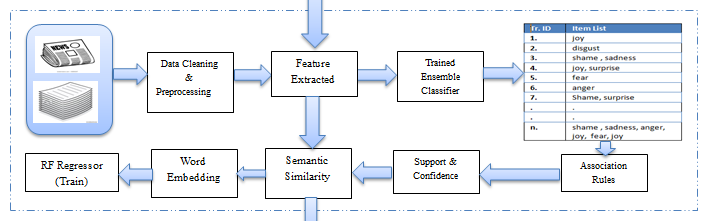

In [1]:
from PIL import Image
Image.open("arc_3.png")

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from nltk.tokenize import word_tokenize
import re
import nltk
#http://rasbt.github.io/mlxtend/
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import warnings 
warnings.filterwarnings("ignore")

import glob
from bs4  import  BeautifulSoup
from nltk.corpus import wordnet as wn

## 1. Loading the data

In [3]:
data = pd.read_csv("data/News_Category_Dataset_v2.csv", header = None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,"{""category"": ""CRIME""","""headline"": ""There Were 2 Mass Shootings In T...","But Only 1 On TV""","""authors"": ""Melissa Jeltsen""","""link"": ""https://www.huffingtonpost.com/entry...","""short_description"": ""She left her husband. H...","""date"": ""2018-05-26""}",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"{""category"": ""ENTERTAINMENT""","""headline"": ""Will Smith Joins Diplo And Nicky...","""authors"": ""Andy McDonald""","""link"": ""https://www.huffingtonpost.com/entry...","""short_description"": ""Of course it has a song.""","""date"": ""2018-05-26""}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{""category"": ""ENTERTAINMENT""","""headline"": ""Hugh Grant Marries For The First...","""authors"": ""Ron Dicker""","""link"": ""https://www.huffingtonpost.com/entry...","""short_description"": ""The actor and his longt...","""date"": ""2018-05-26""}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"{""category"": ""ENTERTAINMENT""","""headline"": ""Jim Carrey Blasts 'Castrato' Ada...","""authors"": ""Ron Dicker""","""link"": ""https://www.huffingtonpost.com/entry...","""short_description"": ""The actor gives Dems an...","""date"": ""2018-05-26""}",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{""category"": ""ENTERTAINMENT""","""headline"": ""Julianna Margulies Uses Donald T...","""authors"": ""Ron Dicker""","""link"": ""https://www.huffingtonpost.com/entry...","""short_description"": ""The \""Dietland\"" actres...","therapeutic moment.\""""","""date"": ""2018-05-26""}",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.shape

(200853, 28)

## 2. loading the headline data

In [6]:
headline_data = data[1]
headline_data.head(10)

0     "headline": "There Were 2 Mass Shootings In T...
1     "headline": "Will Smith Joins Diplo And Nicky...
2     "headline": "Hugh Grant Marries For The First...
3     "headline": "Jim Carrey Blasts 'Castrato' Ada...
4     "headline": "Julianna Margulies Uses Donald T...
5     "headline": "Morgan Freeman 'Devastated' That...
6     "headline": "Donald Trump Is Lovin' New McDon...
7     "headline": "What To Watch On Amazon Prime Th...
8     "headline": "Mike Myers Reveals He'd 'Like To...
9     "headline": "What To Watch On Hulu That\u2019...
Name: 1, dtype: object

In [31]:
#headline_data = headline_data[20000:40000]
len(headline_data)

200853

## 3. Preprocessing

In [15]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)      # replace won't with "will not"
    phrase = re.sub(r"can\'t", "can not", phrase)      # replace can or cant with 'can not'
    phrase = re.sub(r"n\'t", " not", phrase)           # replece n with 'not'
    phrase = re.sub(r"\'re", " are", phrase)           # replace re with 'are'
    phrase = re.sub(r"\'s", " is", phrase)             # replace s with 'is'
    phrase = re.sub(r"\'d", " would", phrase)          # replace 'd' with 'would'
    phrase = re.sub(r"\'ll", " will", phrase)          # replace 'll with 'will'
    phrase = re.sub(r"\'t", " not", phrase)            # replace 't' with 'not'
    phrase = re.sub(r"\'ve", " have", phrase)          # replace ve with 'have'
    phrase = re.sub(r"\'m", " am", phrase)             # replace 'm with 'am'
    return phrase

In [16]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
#print(stopwords)
len(stopwords)

179

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from collections import Counter 

p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text_data):
    preprocessed_text = []             
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)           #calling funcion for each sentence
        #print("1st sent" , sent)
        sent = sent.replace('\\r', ' ')         # replace line terminator with space
        sent = sent.replace('\\n', ' ')         # replace new line charactor with space
        sent = sent.replace('\\"', ' ')    
        sent  = sent.replace('headline',' ')
        #sent  = sent.replace('short_description',' ')
        sent = re.sub('[^A-Za-z]+', ' ', sent)  # remove anything that is not letter
        sent = ''.join(p_stemmer.stem(token) for token in sent )
        sent = ''.join(lemmatizer.lemmatize(token) for token in sent )
        sent  = ' '.join(e for e in sent.split() if len( Counter(e)) > 2 )
        #sent = lstr(emmatize_text(sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords ) # checking for stop words
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [32]:
preprocessed_headline = preprocess_text(headline_data)
#preprocessed_short_discription = preprocess_text(X[1])

100%|██████████| 200853/200853 [01:37<00:00, 2057.53it/s]


In [23]:
preprocessed_headline[0:10]

['mass shootings texas last week',
 'smith joins diplo nicky jam world cup official song',
 'hugh grant marries first time age',
 'jim carrey blasts castrato adam schiff democrats new artwork',
 'julianna margulies uses donald trump poop bags pick dog',
 'morgan freeman devastated sexual harassment claims could undermine legacy',
 'donald trump lovin new mcdonald jingle tonight show bit',
 'watch amazon prime new week',
 'mike myers reveals would like fourth austin powers film',
 'watch hulu new week']

In [33]:
#saving Features file for future use
import pickle
with open('output_files/preprocessed_headline', 'wb') as f:
    pickle.dump(preprocessed_headline, f)

In [28]:
 # Opening preprocessed headline file for further use
import pickle
with open('output_files/preprocessed_headline', 'rb') as f:             
    preprocessed_headline = pickle.load(f)

## 4.loading the enseble classifier model from isear data 

In [22]:
from sklearn.externals import joblib
eclf = joblib.load("saved_model/eclf_ML_Model_.pkl")  # loading the enseble classifier model from isear data 
vectorizer_sit = joblib.load('saved_model/vectorizer_sit.pkl')

### 4.1 sample headline : emotion retrieved 

In [45]:
sample_headline = [preprocessed_headline[10]]
print("\n sample headline :",sample_headline)

preprocessed_txt = vectorizer_sit.transform(sample_headline).toarray()
print("Shape of matrix data after one hot encoding : ",preprocessed_txt.shape)
y_predicted = eclf.predict(preprocessed_txt)
print("Predicted label :",y_predicted)


 sample headline : ['justin timberlake visits texas school shooting victims']
Shape of matrix data after one hot encoding :  (1, 6450)
Predicted label : ['sadness']


### 4.2 Emotion prediction on whole preprocessed headlines

In [30]:
ind = 0
for proctxt in preprocessed_headline:
    ind+=1
    try:
        proctxt = [proctxt]
        preprocessed_txt = vectorizer_sit.transform(proctxt).toarray()
        print("Shape of matrix data after one hot encoding : ",preprocessed_txt.shape)
        y_predicted = eclf.predict(preprocessed_txt)
        
        with open("output_files/headline_predicted.txt", "a+") as oput: # saving the data in text file as Transaction Id and Itemset a/c to AR Rules
            oput.write("  ")
            oput.write(f'\n{ind}\t')                      
            for p in y_predicted:                   # to the len(predict) values creating the dataframe to store index and 
                oput.write(f'{p +" "}')             # predicted value
                #f.write("trnId \t Item list")
            oput.close()
    except:
        print("An exception occurred")

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 

Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one hot encoding :  (1, 6450)
Shape of matrix data after one 